In [ ]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append('/projects/UNet/utils/')

In [6]:
import torch
import matplotlib.pyplot as plt
from dataset import get_dataloaders
from UNet import UNet
from train import train_model
import wandb

config = {
    "dataset_root": "../data",             
    "wandb_project": "CustomUNet", 
    "batch_size": 8,
    "epochs": 40,
    "lr": 1e-3,
    "val_image_interval": 2,
    "save_interval": 5,
    "scheduler_step": 15,
    "scheduler_gamma": 0.5
}

In [7]:
dataloaders = get_dataloaders(config["dataset_root"], batch_size=config["batch_size"])
config["color_list"] = dataloaders["color_list"] 

print("Train batches:", len(dataloaders["train"]))
print("Validation batches:", len(dataloaders["val"]))
print("Test batches:", len(dataloaders["test"]))
print("Color list:", config["color_list"])


Train batches: 8
Validation batches: 1
Test batches: 1
Color list: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']


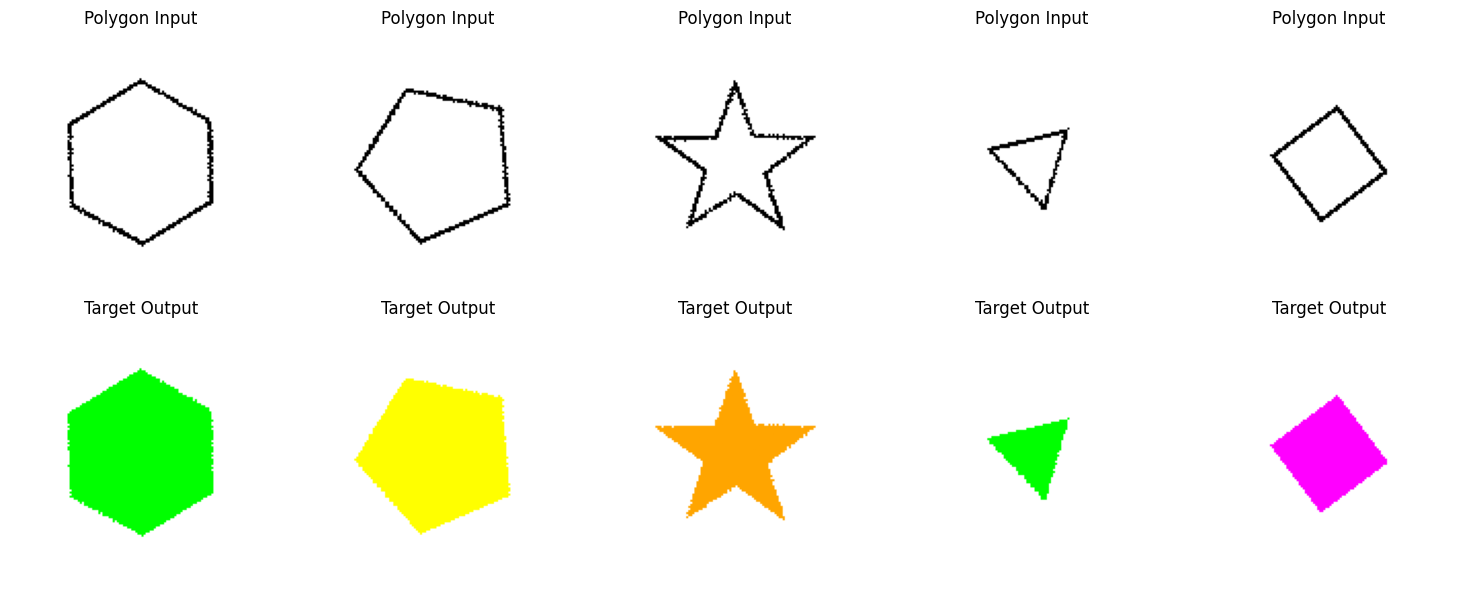

In [8]:
def visualize_batch(dl):
    batch = next(iter(dl))
    x, y = batch
    inputs = x[:, :3, :, :]
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axs[0, i].imshow(inputs[i].permute(1, 2, 0))
        axs[0, i].set_title("Polygon Input")
        axs[1, i].imshow(y[i].permute(1, 2, 0))
        axs[1, i].set_title("Target Output")
    for ax in axs.flatten():
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_batch(dataloaders["train"])


In [9]:
in_channels = 3 + 8 #RGB + 8 conditioning color channels
model = UNet(in_channels=in_channels)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Trainable parameters count
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params:,} i.e, {total_params / 1e6:.2f}M")
print(model)


Trainable parameters: 31,048,259 i.e, 31.05M
UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    

In [10]:
train_model(config,model)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: harishjrao615 (harishjrao615-iiser-bhopal). Use `wandb login --relogin` to force relogin


Epoch 1 | Train Loss: 0.4374
Epoch 2 | Train Loss: 0.3726
Epoch 3 | Train Loss: 0.3220
Epoch 4 | Train Loss: 0.2769
Epoch 5 | Train Loss: 0.2331
Epoch 6 | Train Loss: 0.2036
Epoch 7 | Train Loss: 0.1686
Epoch 8 | Train Loss: 0.1416
Epoch 9 | Train Loss: 0.1203
Epoch 10 | Train Loss: 0.1082
Epoch 11 | Train Loss: 0.0897
Epoch 12 | Train Loss: 0.0843
Epoch 13 | Train Loss: 0.0695
Epoch 14 | Train Loss: 0.0702
Epoch 15 | Train Loss: 0.0594
Epoch 16 | Train Loss: 0.0538
Epoch 17 | Train Loss: 0.0489
Epoch 18 | Train Loss: 0.0468
Epoch 19 | Train Loss: 0.0495
Epoch 20 | Train Loss: 0.0455
Epoch 21 | Train Loss: 0.0430
Epoch 22 | Train Loss: 0.0404
Epoch 23 | Train Loss: 0.0367
Epoch 24 | Train Loss: 0.0336
Epoch 25 | Train Loss: 0.0342
Epoch 26 | Train Loss: 0.0369
Epoch 27 | Train Loss: 0.0337
Epoch 28 | Train Loss: 0.0317
Epoch 29 | Train Loss: 0.0266
Epoch 30 | Train Loss: 0.0260
Epoch 31 | Train Loss: 0.0280
Epoch 32 | Train Loss: 0.0280
Epoch 33 | Train Loss: 0.0267
Epoch 34 | Train Lo

In [ ]:
from huggingface_hub import create_repo, upload_folder

weights_path = "/projects/UNet/results/model_epoch_39.pth"
repo_name = "PolygonColorizingUNet"
hf_username = "Harish-JHR" 
model_dir = "model_upload"

#loading weights and initializing model
in_channels = 3 + 8  # RGB + 8 color condition channels
model = UNet(in_channels=in_channels)
model.load_state_dict(torch.load(weights_path, map_location="cpu"))
model.eval()

# temp dir
os.makedirs(model_dir, exist_ok=True)

# Save weights
torch.save(model.state_dict(), os.path.join(model_dir, "pytorch_model.bin"))

torch.save({
    "in_channels": in_channels,
    "out_channels": 3,
    "architecture": "UNet",
}, os.path.join(model_dir, "config.pt"))


with open(os.path.join(model_dir, "README.md"), "w") as f:
    f.write("# Polygon Colorizer UNet\n")
    f.write("This model fills polygon shapes in an input image with the appropriate color based on conditioning.\n")

full_repo_id = f"{hf_username}/{repo_name}"
create_repo(full_repo_id, exist_ok=True)

upload_folder(
    repo_id=full_repo_id,
    folder_path=model_dir,
    path_in_repo=".",
    commit_message="Upload UNet model with pretrained weights"
)

print(f"Model pushed to: https://huggingface.co/{full_repo_id}")
